In [4]:
# Setup: imports and configuration
import os
import sys
import json
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image, ImageStat, ImageOps

# Display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 160)
sns.set(style="whitegrid")

LABELS_CSV = Path("data/labels.csv")
ATTRIBUTES_YAML = Path("data/attributes.yaml")
IMAGES_ROOT = Path("data/Images")

assert LABELS_CSV.exists(), f"Missing labels.csv at {LABELS_CSV}"
assert ATTRIBUTES_YAML.exists(), f"Missing attributes.yaml at {ATTRIBUTES_YAML}"
assert IMAGES_ROOT.exists(), f"Missing Images directory at {IMAGES_ROOT}"

print("Paths OK:", LABELS_CSV, ATTRIBUTES_YAML, IMAGES_ROOT)


Paths OK: data/labels.csv data/attributes.yaml data/Images


In [5]:
# Load data
labels_df = pd.read_csv(LABELS_CSV)
with open(ATTRIBUTES_YAML, 'r') as f:
    attributes_schema = yaml.safe_load(f)

print(labels_df.head(3))
print("\nAttributes schema keys:", list(attributes_schema.keys()))

# Parse attributes column: "key:value;key:value" -> dict columns

def parse_attributes(attr_str: str) -> dict:
    if pd.isna(attr_str) or not isinstance(attr_str, str) or attr_str.strip() == "":
        return {}
    pairs = [p.strip() for p in attr_str.split(';') if p.strip()]
    out = {}
    for pair in pairs:
        if ':' in pair:
            k, v = pair.split(':', 1)
            out[k.strip()] = v.strip()
    return out

attr_dicts = labels_df['attributes'].apply(parse_attributes)
attr_df = pd.json_normalize(attr_dicts).fillna('unknown')

# Ensure all schema attributes exist as columns
for key in attributes_schema.keys():
    if key not in attr_df.columns:
        attr_df[key] = 'unknown'

labels_df = pd.concat([labels_df, attr_df], axis=1)
print("\nColumns after attribute expansion:", labels_df.columns.tolist())
labels_df.head()


                                               path                 class                                         attributes  \
0  Images/Dataset_jk/Clothing_wrist_watch_A_001.jpg  Clothing_wrist_watch  color:black;material:metal;condition:used;size...   
1  Images/Dataset_jk/Clothing_wrist_watch_A_002.jpg  Clothing_wrist_watch  color:black;material:metal;condition:used;size...   
2  Images/Dataset_jk/Clothing_wrist_watch_A_003.jpg  Clothing_wrist_watch  color:black;material:metal;condition:used;size...   

                                     caption                       instance_id  
0  Black wristwatch with chronograph display  Team2_Clothing_wrist_watch_A_001  
1                           Black wristwatch  Team2_Clothing_wrist_watch_A_002  
2           Black wristwatch with metal band  Team2_Clothing_wrist_watch_A_003  

Attributes schema keys: ['color', 'material', 'condition', 'size']

Columns after attribute expansion: ['path', 'class', 'attributes', 'caption', 'instance_id', '

,path,class,attributes,caption,instance_id,color,material,condition,size
0,Images/Dataset_jk/Clothing_wrist_watch_A_001.jpg,Clothing_wrist_watch,color:black;material:metal;condition:used;size...,Black wristwatch with chronograph display,Team2_Clothing_wrist_watch_A_001,black,metal,used,medium
1,Images/Dataset_jk/Clothing_wrist_watch_A_002.jpg,Clothing_wrist_watch,color:black;material:metal;condition:used;size...,Black wristwatch,Team2_Clothing_wrist_watch_A_002,black,metal,used,medium
2,Images/Dataset_jk/Clothing_wrist_watch_A_003.jpg,Clothing_wrist_watch,color:black;material:metal;condition:used;size...,Black wristwatch with metal band,Team2_Clothing_wrist_watch_A_003,black,metal,used,medium
3,Images/Dataset_jk/Clothing_wrist_watch_A_004.jpg,Clothing_wrist_watch,color:black;material:metal;condition:used;size...,Black wristwatch laying on surface,Team2_Clothing_wrist_watch_A_004,black,metal,used,medium
4,Images/Dataset_jk/Clothing_wrist_watch_A_005.jpg,Clothing_wrist_watch,color:black;material:metal;condition:used;size...,Black wristwatch on surface,Team2_Clothing_wrist_watch_A_005,black,metal,used,medium


/var/folders/d3/sqbhftfj5098vnvkzm_wtxq00000gn/T/ipykernel_45916/3595757183.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.values, y=class_counts.index, ax=axes[0], palette='viridis')


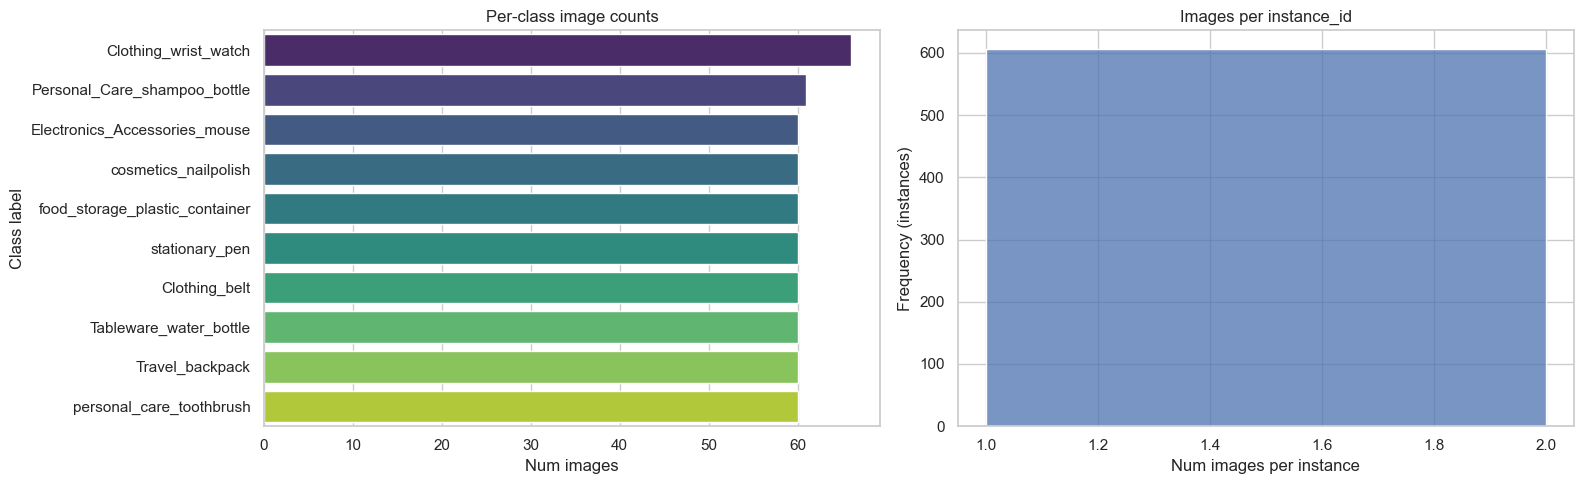

Top 10 classes by count:
 class
Clothing_wrist_watch              66
Personal_Care_shampoo_bottle      61
Electronics_Accessories_mouse     60
cosmetics_nailpolish              60
food_storage_plastic_container    60
stationary_pen                    60
Clothing_belt                     60
Tableware_water_bottle            60
Travel_backpack                   60
personal_care_toothbrush          60
Name: count, dtype: int64

Instance images stats:
count    606.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: path, dtype: float64


In [8]:
# 1) Class & instance stats
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Per-class image counts
class_counts = labels_df['class'].value_counts().sort_values(ascending=False)
sns.barplot(x=class_counts.values, y=class_counts.index, ax=axes[0], palette='viridis')
axes[0].set_title('Per-class image counts')
axes[0].set_xlabel('Num images')
axes[0].set_ylabel('Class label')

# Images per instance_id histogram
images_per_instance = labels_df.groupby('instance_id')['path'].count()
sns.histplot(images_per_instance, bins=range(1, images_per_instance.max()+2), ax=axes[1], kde=False)
axes[1].set_title('Images per instance_id')
axes[1].set_xlabel('Num images per instance')
axes[1].set_ylabel('Frequency (instances)')

plt.tight_layout()
plt.show()

print("Top 10 classes by count:\n", class_counts.head(10))
print("\nInstance images stats:")
print(images_per_instance.describe())


/var/folders/d3/sqbhftfj5098vnvkzm_wtxq00000gn/T/ipykernel_45916/362746318.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='mako')
/var/folders/d3/sqbhftfj5098vnvkzm_wtxq00000gn/T/ipykernel_45916/362746318.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='mako')
/var/folders/d3/sqbhftfj5098vnvkzm_wtxq00000gn/T/ipykernel_45916/362746318.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='ma

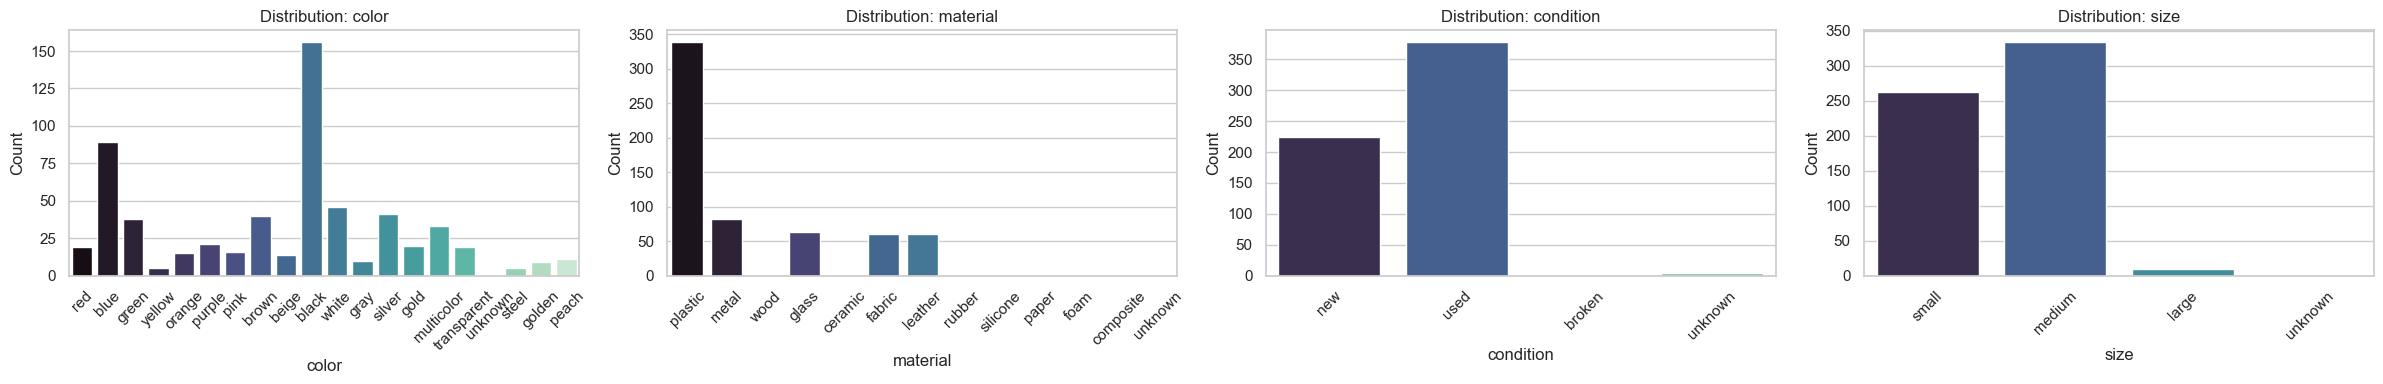

Per-class top attribute values (first few):

[color]
 class                                     
Clothing_belt                   black         35
Clothing_wrist_watch            silver        25
Electronics_Accessories_mouse   black         42
Personal_Care_shampoo_bottle    white         25
Tableware_water_bottle          blue          15
Travel_backpack                 black         40
cosmetics_nailpolish            pink           9
food_storage_plastic_container  brown          9
personal_care_toothbrush        multicolor    30
stationary_pen                  blue          29
Name: color, dtype: int64

[material]
 class                                  
Clothing_belt                   leather    55
Clothing_wrist_watch            metal      56
Electronics_Accessories_mouse   plastic    60
Personal_Care_shampoo_bottle    plastic    61
Tableware_water_bottle          plastic    35
Travel_backpack                 fabric     60
cosmetics_nailpolish            glass      41
food_storage

In [10]:
# 2) Attribute distributions
attr_keys = list(attributes_schema.keys())
num_attrs = len(attr_keys)
fig, axes = plt.subplots(1, num_attrs, figsize=(6*num_attrs, 4))
if num_attrs == 1:
    axes = [axes]

for ax, key in zip(axes, attr_keys):
    counts = labels_df[key].value_counts().reindex(attributes_schema[key], fill_value=0)
    sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='mako')
    ax.set_title(f"Distribution: {key}")
    ax.set_xlabel(key)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Also show per-class top attributes for a quick glance
summary = {}
for key in attr_keys:
    top_vals = labels_df.groupby('class')[key].apply(lambda s: s.value_counts().head(1))
    summary[key] = top_vals

print("Per-class top attribute values (first few):")
for key in attr_keys:
    print(f"\n[{key}]\n", summary[key].head(10))


In [14]:
# 3) Risk examples (3–5): glare, color ambiguity, look-alikes
from typing import List, Tuple

# Define PROJECT_ROOT as current directory
PROJECT_ROOT = Path.cwd()

def _safe_open_image(path: Path):
    try:
        return Image.open(path).convert('RGB')
    except Exception:
        return None


def _image_brightness(img: Image.Image) -> float:
    # Simple brightness metric: mean over grayscale
    gray = ImageOps.grayscale(img)
    stat = ImageStat.Stat(gray)
    return float(stat.mean[0])


# Build absolute paths and filter to existing files
labels_df['abs_path'] = labels_df['path'].apply(lambda p: (PROJECT_ROOT / p))
labels_existing = labels_df[labels_df['abs_path'].apply(lambda p: p.exists())].copy()

examples: List[Tuple[str, Path]] = []

# A) Glare candidate: highest brightness image
if not labels_existing.empty:
    brightness_scores = []
    for _, row in labels_existing.iterrows():
        img = _safe_open_image(row['abs_path'])
        if img is None:
            continue
        brightness_scores.append((_image_brightness(img), row))
    if brightness_scores:
        brightness_scores.sort(key=lambda x: x[0], reverse=True)
        top_brightness_row = brightness_scores[0][1]
        examples.append((f"Glare/bright candidate: {_image_brightness(_safe_open_image(top_brightness_row['abs_path'])):.1f}", top_brightness_row['abs_path']))

# B) Color ambiguity: color == unknown or multicolor
color_ambig = labels_existing[labels_existing['color'].isin(['unknown', 'multicolor'])]
if not color_ambig.empty:
    row = color_ambig.iloc[0]
    examples.append((f"Color ambiguity: {row['color']}", row['abs_path']))

# C) Look-alikes: two different instance_ids from same class
class_sizes = labels_existing.groupby('class')['instance_id'].nunique().sort_values(ascending=False)
if not class_sizes.empty:
    class_candidate = class_sizes.index[0]
    subset = labels_existing[labels_existing['class'] == class_candidate]
    inst_per_class = subset.groupby('instance_id').size().sort_values(ascending=False)
    inst_ids = inst_per_class.index.tolist()[:2]
    for iid in inst_ids:
        first_img = subset[subset['instance_id'] == iid].iloc[0]
        examples.append((f"Look-alike within class {class_candidate}: {iid}", first_img['abs_path']))

# De-duplicate by path and cap to 5
seen = set()
unique_examples = []
for title, p in examples:
    if p not in seen:
        unique_examples.append((title, p))
        seen.add(p)
    if len(unique_examples) >= 5:
        break

n = len(unique_examples)
if n == 0:
    print("No risk examples could be selected (no images found).")
else:
    cols = min(5, n)
    rows = 1
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4))
    if n == 1:
        axes = [axes]
    for ax, (title, p) in zip(axes, unique_examples):
        img = _safe_open_image(p)
        ax.imshow(img)
        ax.set_title(title, fontsize=10)
        ax.axis('off')
    for ax in (axes[len(unique_examples):] if n < cols else []):
        ax.axis('off')
    plt.tight_layout()
    plt.show()


No risk examples could be selected (no images found).
